In [1]:
%%capture
! pip install librosa
! pip install torch

In [51]:
import os
import pandas as pd
import s3fs
import zipfile
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
from CustomDataset import CustomDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import librosa
from Misc import Misc
from scipy import signal
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [12]:
DATASET_PATH = "../data/LivingRoom_preprocessed_hack"
# Dimensions of the living room
X_MIN = -4000
X_MAX = 500
Y_MIN = -4000
Y_MAX = 2000
MISC = Misc(start_time=0, end_time=50000, sr=44100, target_sr=16000)

## Read Data

In [5]:
centroids_h1 = np.load(DATASET_PATH + "/Human1/centroid.npy")
centroids_h2 = np.load(DATASET_PATH + "/Human2/centroid.npy")
deconvoled_trim_h1 = np.load(DATASET_PATH + "/Human1/deconvoled_trim.npy")
deconvoled_trim_h2 = np.load(DATASET_PATH + "/Human2/deconvoled_trim.npy")

In [6]:
print("Deconvoled Trim Human 1 Shape: ", deconvoled_trim_h1.shape)
print("Deconvoled Trim Human 2 Shape: ", deconvoled_trim_h2.shape)
print("Centroids Huma 1 Shape: ", centroids_h1.shape)
print("Centroids Human 2 Shape: ", centroids_h2.shape)

Deconvoled Trim Human 1 Shape:  (1000, 4, 667200)
Deconvoled Trim Human 2 Shape:  (104, 4, 667200)
Centroids Huma 1 Shape:  (1000, 2)
Centroids Human 2 Shape:  (104, 2)


## Normalize Coordinates

In [7]:
def normalize_coordinates(centroids):
    room_width = X_MAX - X_MIN
    room_height = Y_MAX - Y_MIN

    centroids[:, 0] = (centroids[:, 0] - X_MIN) / room_width
    centroids[:, 1] = (centroids[:, 1] - Y_MIN) / room_height
    return centroids

centroids_h1 = normalize_coordinates(centroids_h1)
centroids_h2 = normalize_coordinates(centroids_h2)

## PCA Decomposition

In [ ]:
from sklearn.decomposition import IncrementalPCA

# Define the number of components for IPCA
n_components = 415

# Initialize IPCA
ipca_h1 = IncrementalPCA(n_components=n_components)
ipca_h2 = IncrementalPCA(n_components=n_components)

# Iterate over the data in batches and fit IPCA incrementally
batch_size = 500  # Adjust the batch size as needed
print("Fitting IPCA for Human 1:")
for i in tqdm(range(batch_size)):
    start = i * batch_size
    end = min((i + 1) * batch_size, reshaped_data_h1.shape[0])
    batch_data_h1 = reshaped_data_h1[start:end]
    ipca_h1.partial_fit(batch_data_h1)

print("Fitting IPCA for Human 2:")
for i in tqdm(range(batch_size)):
    start = i * batch_size
    end = min((i + 1) * batch_size, reshaped_data_h2.shape[0])
    batch_data_h2 = reshaped_data_h2[start:end]
    ipca_h2.partial_fit(batch_data_h2)

# Transform the data into the reduced dimensionality space
transformed_data_h1 = ipca_h1.transform(reshaped_data_h1)
transformed_data_h2 = ipca_h2.transform(reshaped_data_h2)
num_instances_h1, num_channels_h1, _ = deconvoled_trim_h1.shape
num_instances_h2, num_channels_h2, _ = deconvoled_trim_h2.shape

# Reshape the transformed data back to the original multi-channel shape
transformed_data_h1 = transformed_data_h1.reshape(num_instances_h1, num_channels_h1, -1)
transformed_data_h2 = transformed_data_h2.reshape(num_instances_h2, num_channels_h2, -1)



reshaped_mfcc_h1 = preprocessed_data_mfcc_h1.reshape((-1, preprocessed_data_mfcc_h1.shape[-1]))
reshaped_mfcc_h2 = preprocessed_data_mfcc_h2.reshape((-1, preprocessed_data_mfcc_h2.shape[-1]))

pca_h1 = PCA(n_components=0.95)
pca_h2 = PCA(n_components=0.95) 

pca_h1.fit(reshaped_mfcc_h1)
pca_h2.fit(reshaped_mfcc_h2)

transformed_mfcc_h1 = pca_h1.transform(reshaped_mfcc_h1)
transformed_mfcc_h2 = pca_h2.transform(reshaped_mfcc_h2)

inverse_transformed_mfcc_h1 = pca_h1.inverse_transform(transformed_mfcc_h1)
inverse_transformed_mfcc_h2 = pca_h2.inverse_transform(transformed_mfcc_h2)

inverse_transformed_mfcc_h1 = inverse_transformed_mfcc_h1.reshape(preprocessed_data_mfcc_h1.shape)
inverse_transformed_mfcc_h2 = inverse_transformed_mfcc_h2.reshape(preprocessed_data_mfcc_h2.shape)

print("Transformed MFCC Human 1 data shape:", transformed_mfcc_h1.shape)
print("Transformed MFCC Human 2 data shape:", transformed_mfcc_h2.shape)
print("Inverse transformed MFCC Human 1 data shape:", inverse_transformed_mfcc_h1.shape)
print("Inverse transformed MFCC Human 2 data shape:", inverse_transformed_mfcc_h2.shape)

## Preprocessing

In [14]:
preprocessed_data_mfcc_h1, preprocessed_data_rms_h1, preprocessed_data_zcr_h1 = MISC.preprocess(deconvoled_trim=deconvoled_trim_h1)
preprocessed_data_mfcc_h2, preprocessed_data_rms_h2, preprocessed_data_zcr_h2 = MISC.preprocess(deconvoled_trim=deconvoled_trim_h2)

100%|██████████| 104/104 [00:03<00:00, 34.31it/s]


In [22]:
print("Preprocessed RMS Human 1 data: ", preprocessed_data_rms_h1.shape)
print("Preprocessed Zero-Crossing Rate Human 1 data: ", preprocessed_data_zcr_h1.shape)
print("Preprocessed MFCC Human 1 data: ", preprocessed_data_mfcc_h1.shape)
print("Preprocessed RMS Human 2 data: ", preprocessed_data_rms_h2.shape)
print("Preprocessed Zero-Crossing Rate Human 2 data: ", preprocessed_data_zcr_h2.shape)
print("Preprocessed MFCC Human 2 data: ", preprocessed_data_mfcc_h2.shape)

Preprocessed RMS Human 1 data:  (1000, 4)
Preprocessed Zero-Crossing Rate Human 1 data:  (1000, 4, 1, 98)
Preprocessed MFCC Human 1 data:  (1000, 4, 20, 98)
Preprocessed RMS Human 2 data:  (104, 4)
Preprocessed Zero-Crossing Rate Human 2 data:  (104, 4, 1, 98)
Preprocessed MFCC Human 2 data:  (104, 4, 20, 98)


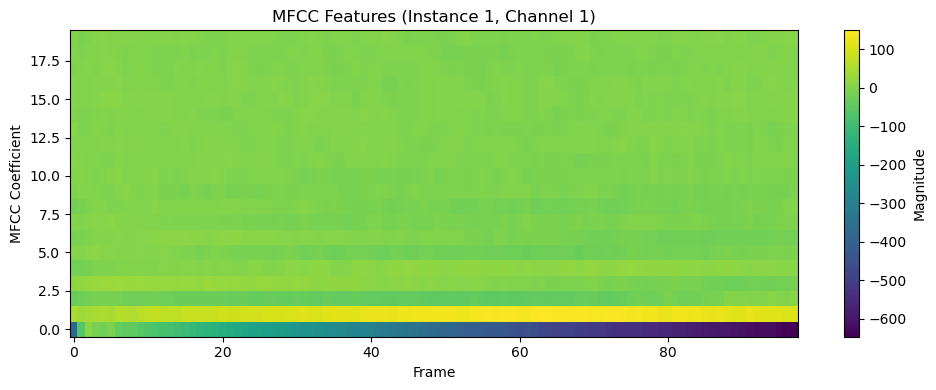

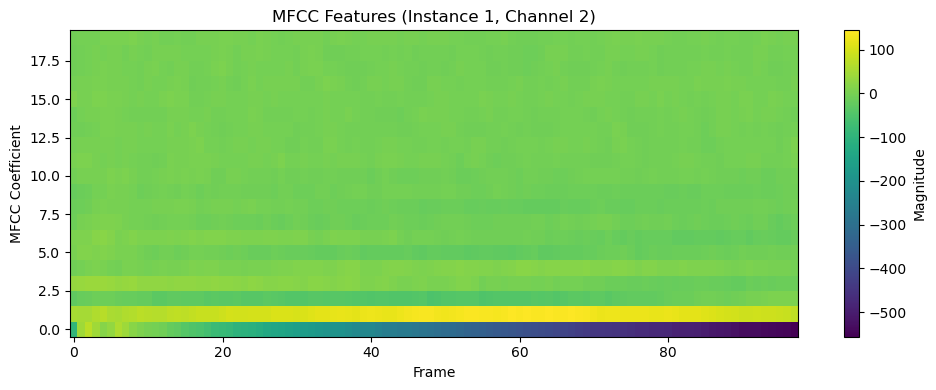

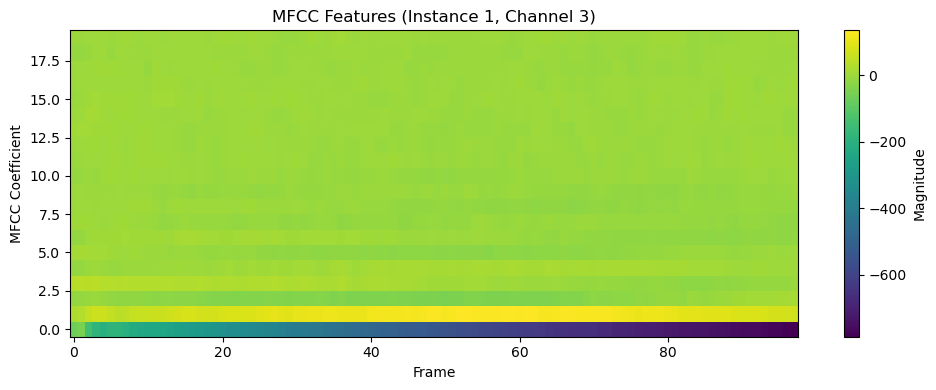

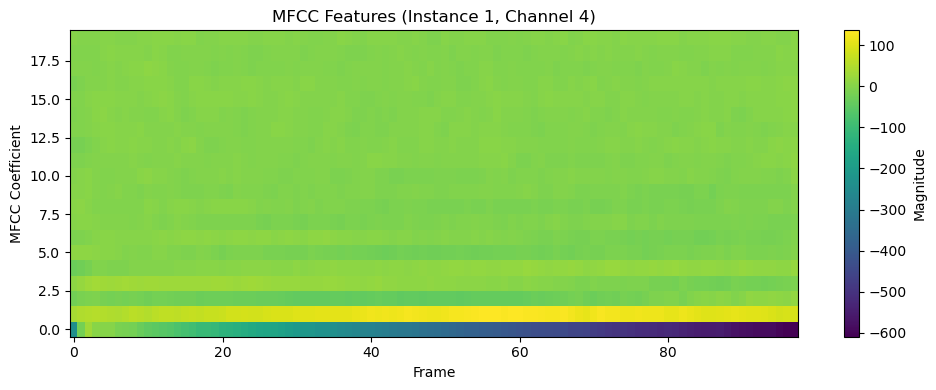

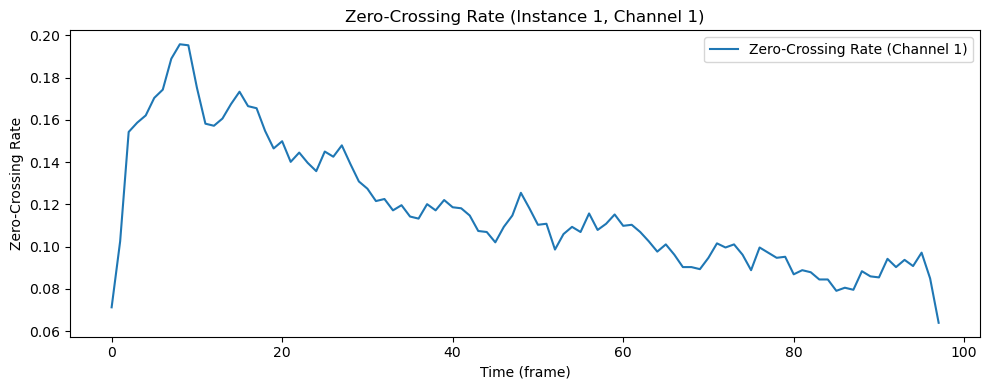

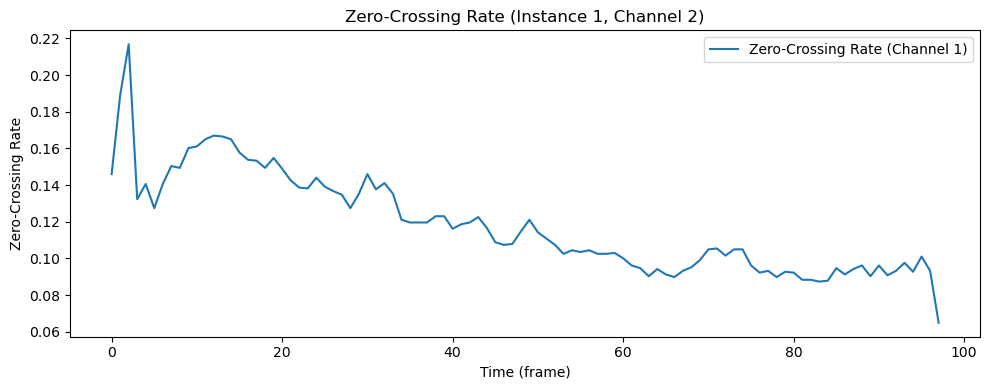

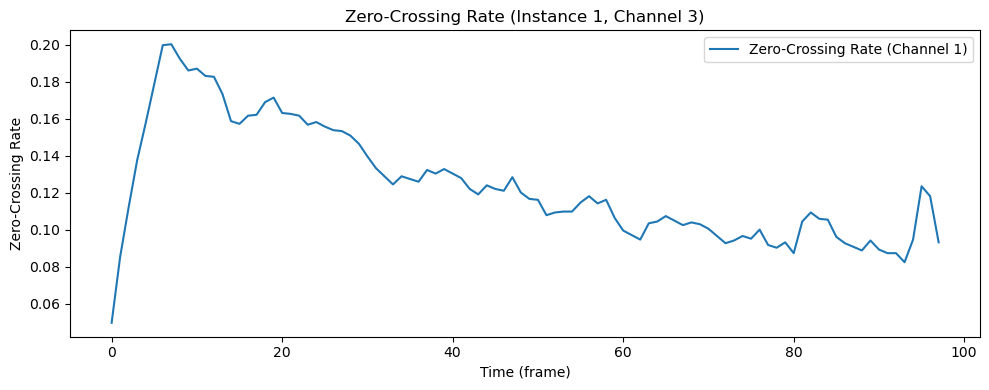

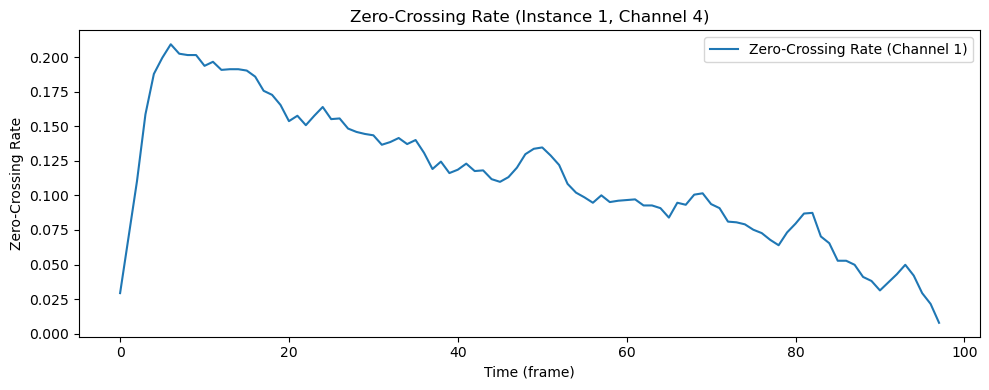

In [30]:
# Plot audio features for each instance and channel
for instance_index in range(preprocessed_data_mfcc_h2.shape[0]):
    for channel_index in range(preprocessed_data_mfcc_h2.shape[1]):
        mfcc_features = preprocessed_data_mfcc_h2[instance_index, channel_index]
        MISC.plot_audio_features(instance_index=instance_index, chan_index=channel_index, mfcc=mfcc_features)
    break

# Plot audio features for each instance and channel
for instance_index in range(preprocessed_data_zcr_h2.shape[0]):
    for channel_index in range(preprocessed_data_zcr_h2.shape[1]):
        zero_crossing_rate = preprocessed_data_zcr_h2[instance_index, channel_index] 
        MISC.plot_audio_features(instance_index=instance_index, chan_index=channel_index, zcr=zero_crossing_rate)
    break

## Dataset

In [38]:
dataset_h1 = CustomDataset(preprocessed_data_rms=preprocessed_data_rms_h1, coordinates=centroids_h1)
dataset_h2 = CustomDataset(preprocessed_data_rms=preprocessed_data_rms_h2, coordinates=centroids_h2)

# Access a sample from the dataset
features_list, coordinates = dataset_h1[1]
print("Features List Length:", len(features_list))
print("Features Shape (Microphone 1):", features_list[0])
print("Features Shape (Microphone 2):", features_list[1])
print("Features Shape (Microphone 3):", features_list[2])
print("Features Shape (Microphone 4):", features_list[3])
print("Coordinates:", coordinates)

RMS:  (1000, 4)
RMS:  (104, 4)
Features List Length: 4
Features Shape (Microphone 1): 0.034632757
Features Shape (Microphone 2): 0.05031347
Features Shape (Microphone 3): 0.013751095
Features Shape (Microphone 4): 0.030503418
Coordinates: tensor([0.1781, 0.5426])


## Linear Regression Model

In [39]:
class MyLinearRegression(nn.Module):
    def __init__(self, input_size=4, output_size=2):
        super(MyLinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.linear(x)
        return out

In [40]:
batch_size = 64
train_loader = DataLoader(dataset=dataset_h1, batch_size=batch_size, shuffle=True)

## Training

In [41]:
input_size = 4  # 4 microphones
output_size = 2  # x, y coordinates
pytorch_model = MyLinearRegression(input_size=input_size, output_size=output_size)
sk_learn_model = LinearRegression()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(pytorch_model.parameters(), lr=0.0001)
num_epochs = 20

In [42]:
sk_learn_model.fit(dataset_h1.preprocessed_data_rms, dataset_h1.coordinates)

LinearRegression()

In [48]:
def euclidean_distance2(pred_coords, true_coords):
    if not isinstance(pred_coords, np.ndarray):
        pred_coords = pred_coords.numpy()
    if not isinstance(true_coords, np.ndarray):
        pred_coords = true_coords.numpy()
    return np.sqrt(np.sum((pred_coords - true_coords)**2))

In [52]:
# Make predictions on the validation set
val_predictions = sk_learn_model.predict(dataset_h2.preprocessed_data_rms)

# Calculate localization errors for each prediction
errors = []
for pred_coords, true_coords in zip(val_predictions, dataset_h2.coordinates):
    error = MISC.euclidean_distance(pred_coords, true_coords)
    errors.append(error)

errors = np.array(errors)
mean_error = np.mean(errors)
stdev_error = np.std(errors)

print("Localization Error: {:.2f} ({:.2f})".format(mean_error, stdev_error))
print("Score: ", sk_learn_model.score(dataset_h1.preprocessed_data_rms, dataset_h1.coordinates))

AttributeError: 'Misc' object has no attribute 'euclidean_distance'

In [53]:
for epoch in range(num_epochs):
    pytorch_model.train()
    train_loss = 0.0
    for rms, coordinates in train_loader:
        optimizer.zero_grad()
        outputs = pytorch_model(rms)
        loss = euclidean_distance2(outputs, coordinates)
        loss.backward()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
pytorch_model.eval()
predicted_coordinates = []

for rms, coordinates in dataset_h2:
    # Forward pass to get the predicted coordinates
    with torch.no_grad():  # Disable gradient tracking during inference
        outputs = pytorch_model(torch.tensor(rms))
    
    # Append the predicted coordinates to the list
    predicted_coordinates.append(outputs)

# Convert the list of predicted coordinates to a single tensor
predicted_coordinates = np.array(predicted_coordinates)

In [ ]:
errors = []
for pred_coords, true_coords in zip(predicted_coordinates, dataset_h2.coordinates):
    error = euclidean_distance(pred_coords, true_coords)
    errors.append(error)

errors = np.array(errors)
mean_error = np.mean(errors)
stdev_error = np.std(errors)

print("Localization Error: {:.2f} ({:.2f})".format(mean_error, stdev_error))

In [ ]:
# Concatenate all true and predicted coordinates from all data points
all_true_coords = dataset_h2.coordinates.reshape(-1, 2)
all_pred_coords = predicted_coordinates.reshape(-1, 2)

# Plot all true and predicted coordinates on a single graph
plt.figure(figsize=(8, 6))
plt.scatter(all_true_coords[:, 0], all_true_coords[:, 1], color='blue', label='True Coordinates')
#plt.scatter(all_pred_coords[:, 0], all_pred_coords[:, 1], color='red', label='Predicted Coordinates')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('True vs Predicted Coordinates')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Concatenate all true and predicted coordinates from all data points
all_true_coords = dataset_h2.coordinates.reshape(-1, 2)
all_pred_coords = predicted_coordinates.reshape(-1, 2)

# Plot all true and predicted coordinates on a single graph
plt.figure(figsize=(8, 6))
#plt.scatter(all_true_coords[:, 0], all_true_coords[:, 1], color='blue', label='True Coordinates')
plt.scatter(all_pred_coords[:, 0], all_pred_coords[:, 1], color='red', label='Predicted Coordinates')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('True vs Predicted Coordinates')
plt.legend()
plt.grid(True)
plt.show()

## Zero-Crossing Rate

In [ ]:
dataset_h1 = CustomDataset(preprocessed_data_zcr=preprocessed_data_zcr_h1, _type="zcr", coordinates=centroids_h1)
dataset_h2 = CustomDataset(preprocessed_data_zcr=preprocessed_data_zcr_h2, _type="zcr", coordinates=centroids_h2)

# Split the data into training and testing sets
rms_features = np.sqrt(np.mean(dataset_h1.preprocessed_data_zcr**2, axis=-1))
X_train = rms_features.reshape(1000, 4)
y_train = dataset_h1.coordinates
rms_features = np.sqrt(np.mean(dataset_h2.preprocessed_data_zcr**2, axis=-1))
X_test = rms_features.reshape(104, 4)
y_test = dataset_h2.coordinates

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
# print("Score: ", model.score(X_test, y_test))

errors = []
for pred_coords, true_coords in zip(y_pred, dataset_h2.coordinates):
    error = euclidean_distance(pred_coords, true_coords)
    errors.append(error)

errors = np.array(errors)
mean_error = np.mean(errors)
stdev_error = np.std(errors)

print("Localization Error: {:.2f} ({:.2f})".format(mean_error, stdev_error))